In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext lab_black
# or nb_black

# Imports and data

In [3]:
import pickle
import json
from ecommercerecommendation.utils.data import get_data, venn_sets

from ecommercerecommendation.models.tfidfrecommender import TfIdfRecommender
from ecommercerecommendation.models.llmrecommender import LLMRecommender
from ecommercerecommendation.models.cfrecommender import CFRecommender
from ecommercerecommendation.models.arrecommender import ARRecommender

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [4]:
df = get_data("clean_data")

In [5]:
print("Columns: " + ", ".join(df.columns))

Columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country


Available information/features:
- **InvoiceNo:** to know what products were purchased together
- **CustomerID:** to know what products were bought together by a customer
- **StockCode:** product ID
- **Description:** For future text-based/LLM solutions
- **Quantity:** Is it important?
- **UnitPrice:** Is it important? Maybe for tabular data
- **InvoiceDate:** for date values like month, day of the week etc, maybe hour of the day?
- **Country:** OHE if needed later

## Train-test-split

We will use a 80-20 split by InvoiceDate in order to prevent data leakage.

In [6]:
cut_off_date = df["InvoiceDate"].quantile(0.8)
df["train"] = df["InvoiceDate"] <= cut_off_date

In [7]:
X_train = df[df["train"]].drop(columns="train")
X_test = df[~df["train"]].drop(columns="train")

In [8]:
# to check whether we have successfully separated all transactions:
# union, only 1st, intersection, only 2nd
venn_sets(set(X_train["InvoiceNo"]), set(X_test["InvoiceNo"]))

'[18305]: [ 14990 - (0) - 3315 ]'

## Recommendations

We are given an implicit feedback recommendation problem. Feedback: whether the user have bought the product (1) or not (0).

Firstly, I will consider the following two options:
- **Association rules:** to see what products are bought together (by basket or by customer -- we will consider by basket now)
- **Collaborative filtering:** by user behaviour, what other users have purchased having some elements in the basket.

I will **not** consider Matrix Factorisation (SVD; as we do not know if the quantity represents popularity or if depends on the product), Content based filtering (using tf-idf or similar; we leave text data for later, for the LLM solution), RFM based solutions (user clustering by recency, frequency and monatery features; that would be a wider project, skipping it for now).

### Train-test customer and stock distribution

To see how much customers and products are separated by the train-test split, and how much intersection they have 

`[union]: [only set1, intersection, only set2]`

In [9]:
train_customers = set(X_train["CustomerID"])
test_customers = set(X_test["CustomerID"])

train_stocks = set(X_train["StockCode"])
test_stocks = set(X_test["StockCode"])

print(f"Customers: {venn_sets(train_customers, test_customers)}")
print(f"Stocks: {venn_sets(train_stocks, test_stocks)}")

Customers: [4322]: [ 2451 - (1522) - 349 ]
Stocks: [3183]: [ 655 - (2493) - 35 ]


There are only a few new products in the test set.

### Descriptions for later

In [10]:
stock_description_dict = (
    df.groupby("StockCode")["Description"].unique().apply(list).to_dict()
)

# appr 14% of them have more than one descriptions

We have multiple descriptions per stock such as:

```json
value = [
    "ORIGAMI ROSE INCENSE/CANDLE SET",
    "ORIGAMI JASMINE INCENSE/CANDLE SET",
    "ORIGAMI OPIUM INCENSE/CANDLE SET",
    "ORIGAMI SANDLEWOOD INCENSE/CAND SET",
    "ORIGAMI LAVENDER INCENSE/CANDL SET",
    "ORIGAMI VANILLA INCENSE/CANDLE SET",
]```

We can extract the common words (keeping the order of the first appeareance, in case they are different as follows:

In [11]:
stock_unique_description_dict = {
    key: " ".join(
        [
            word
            for word in value[0].split(" ")
            if word in set.intersection(*[set(desc.split(" ")) for desc in value])
        ]
    )
    for key, value in stock_description_dict.items()
}

We can see the change in the beginning of the dictionary/json file 

In [12]:
print("..." + json.dumps(stock_description_dict, indent=4)[117:350] + "...")

...
    "10120": [
        "DOGGY RUBBER"
    ],
    "10123": [
        "HEARTS WRAPPING TAPE"
    ],
    "10124": [
        "ARMY CAMO BOOKCOVER TAPE",
        "SPOTS ON RED BOOKCOVER TAPE"
    ],
    "10125": [
        "MINI FUNKY DES...


In [13]:
print("..." + json.dumps(stock_unique_description_dict, indent=4)[85:210] + "...")

...
    "10120": "DOGGY RUBBER",
    "10123": "HEARTS WRAPPING TAPE",
    "10124": "BOOKCOVER TAPE",
    "10125": "MINI FUNKY DE...


In [14]:
# to have it saved in a safe way
with open("cache/descriptions.pkl", "wb") as file:
    pickle.dump(stock_description_dict, file)

# in case we want to have a look at
with open("cache/descriptions_dict.json", "wt") as file:
    json.dump(stock_description_dict, file, indent=4)

    # to have it saved in a safe way
with open("cache/unique_descriptions.pkl", "wb") as file:
    pickle.dump(stock_unique_description_dict, file)

# in case we want to have a look at
with open("cache/unique_descriptions.json", "wt") as file:
    json.dump(stock_unique_description_dict, file, indent=4)

In [15]:
with open("cache/customers.pkl", "wb") as file:
    pickle.dump(sorted(df["CustomerID"].unique()), file)

### Dataset for association rules and filtering 

In [16]:
df[["InvoiceNo", "StockCode", "CustomerID", "train"]].to_csv(
    "cache/data_rule_based.csv", index=False, encoding="utf-8"
)

# Rule based recommendations

In [17]:
df = get_data("data_rule_based")

## Invoices and customers

In [18]:
print(f"Number of invoices: {df['InvoiceNo'].nunique()}")

Number of invoices: 18305


Number of products per invoice, inverse cummulative sum to see what % have at least 2-3 products:

In [19]:
(
    100
    * df.groupby("InvoiceNo")["StockCode"]
    .nunique()
    .value_counts()
    .sort_index(ascending=False)
    / df["InvoiceNo"].nunique()
).cumsum().round(2).astype(str).tail(5) + "%"

StockCode
5    81.81%
4    85.35%
3    88.87%
2    92.77%
1    100.0%
Name: count, dtype: object

Most of the have at least 2 products per invoice.

In [20]:
print(f"Number of invoices: {df['CustomerID'].nunique()}")

Number of invoices: 4322


In [21]:
(
    100
    * df.groupby("CustomerID")["StockCode"]
    .nunique()
    .value_counts()
    .sort_index(ascending=False)
    / df["CustomerID"].nunique()
).cumsum().round(2).astype(str).tail(5) + "%"

StockCode
5    93.71%
4    94.96%
3    96.53%
2    97.69%
1    100.0%
Name: count, dtype: object

Most customers get more than 1 product.

<Axes: >

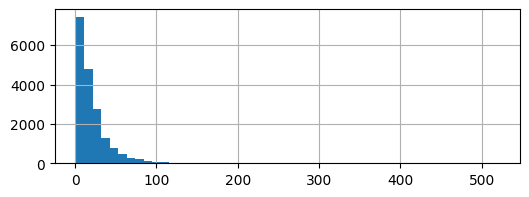

In [23]:
df.groupby("InvoiceNo")["StockCode"].nunique().hist(bins=50, figsize=(6, 2))

<Axes: >

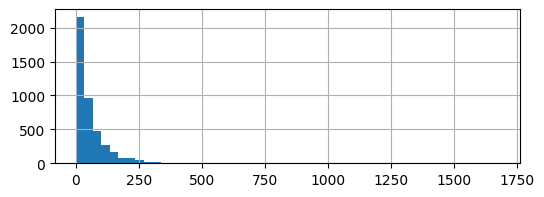

In [24]:
df.groupby("CustomerID")["StockCode"].nunique().hist(bins=50, figsize=(6, 2))

## Association rules

We will consider invoices as transactions. We will work on the training set.

We predict based on a set of already chosen products as input.

### Training

In [25]:
ar_recommender = ARRecommender()

In [26]:
ar_recommender.fit(X_train)

ARRecommender()

In [27]:
ar_recommender.save_pickle("AR_model.pkl")

### Examples

In [28]:
ar_recommender.rules[ar_recommender.rules["confidence"] > 0.5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1515,"(23170, 23172)",(23171),0.012075,0.016344,0.011541,0.955801,58.479423,0.011344,22.255212,0.994913
888,(22916),(22917),0.011408,0.011474,0.010674,0.935673,81.544948,0.010543,15.367081,0.999135
889,(22917),(22916),0.011474,0.011408,0.010674,0.930233,81.544948,0.010543,14.169824,0.999202
1516,"(23171, 23172)",(23170),0.012408,0.019746,0.011541,0.930108,47.102405,0.011296,14.025165,0.991067
899,(22918),(22917),0.011207,0.011474,0.010407,0.928571,80.926080,0.010278,13.839360,0.998837
...,...,...,...,...,...,...,...,...,...,...
721,(22383),(20725),0.060907,0.074850,0.030620,0.502738,6.716619,0.026062,1.860489,0.906317
990,(21668),(21670),0.020080,0.017011,0.010073,0.501661,29.489805,0.009732,1.972531,0.985887
810,"(85099, 22383)",(20728),0.021414,0.056571,0.010740,0.501558,8.865977,0.009529,1.892754,0.906624
1266,"(23201, 85099)",(23199),0.022081,0.040761,0.011074,0.501511,12.303836,0.010174,1.924293,0.939469


In [29]:
ar_recommender.rules["antecedents"].apply(len).value_counts()

antecedents
1    1124
2     390
3      20
Name: count, dtype: int64

### Evaluation

In [30]:
hit_rate, hits, opportunities = ar_recommender.evaluate_rules(X=X_test, sample_perc=0.1)

In [31]:
print(f"Hit Rate on Test Set: {hit_rate:.2%}")

Hit Rate on Test Set: 0.00%


## Collaborative Filtering

By user; what other products have the other users bought together with the given products.

We predict based on either a `customerId`, if known or on a set of already chosen products as input.

In [32]:
cf_recommender = CFRecommender()

In [33]:
cf_recommender.fit(X_train)

CFRecommender()

In [34]:
# cf_recommender.save_pickle("CF_model.pkl")

In [35]:
# customer distribution in the train-test set:
venn_sets(train_customers, test_customers)

'[4322]: [ 2451 - (1522) - 349 ]'

There are some new customers in the test set. In case we don't find a customer, we can always predict by some products they have already purchased.

### Some examples

#### Known customer

In [36]:
# recommendation for existing customer:
customer_id = 12680

In [37]:
recommendation = cf_recommender.get_recommendations(12680)

In [38]:
[
    f"{key}: {value}"
    for key, value in stock_description_dict.items()
    if key in recommendation
]

["22467: ['GUMBALL COAT RACK']",
 "22551: ['PLASTERS IN TIN SPACEBOY']",
 "22659: ['LUNCH BOX I LOVE LONDON']",
 "22725: ['ALARM CLOCK BAKELIKE CHOCOLATE']",
 "22729: ['ALARM CLOCK BAKELIKE ORANGE']"]

#### New customer

In [39]:
customer_id = 1  # new for sure
chosen_stocks = [84029, 23254]
[
    f"{key}: {value}"
    for key, value in stock_description_dict.items()
    if key in chosen_stocks
]

["23254: ['CHILDRENS CUTLERY DOLLY GIRL', 'KIDS CUTLERY DOLLY GIRL']",
 "84029: ['KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART']"]

In [40]:
recommendation = cf_recommender.get_recommendations(
    target_user=customer_id, selected_stocks=chosen_stocks
)

In [41]:
[
    f"{key}: {value}"
    for key, value in stock_description_dict.items()
    if key in recommendation
]

["21730: ['GLASS STAR FROSTED T-LIGHT HOLDER']",
 "22632: ['HAND WARMER RED POLKA DOT', 'HAND WARMER RED RETROSPOT']",
 "22633: ['HAND WARMER UNION JACK']",
 "71053: ['WHITE METAL LANTERN', 'WHITE MOROCCAN METAL LANTERN']",
 "85123: ['WHITE HANGING HEART T-LIGHT HOLDER', 'CREAM HANGING HEART T-LIGHT HOLDER']"]

#### For test set

In [42]:
y_test = cf_recommender.transform(X_test)

In [43]:
X_test.iloc[[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
311252,573937,23379,PACK OF 12 RED APPLE TISSUES,24,2011-11-02 10:40:00,0.39,15830,United Kingdom


In [44]:
[
    f"{key}: {value}"
    for key, value in stock_description_dict.items()
    if key in y_test.iloc[0]
]

[]

In [45]:
# For the evaluation we can use <get_recommendations>

## Content based filtering

We can use the information given in the description (and maybe the country), vectorising it using tf-idf. This can be replaced by an LLM later to have a better representation.

In [46]:
df = get_data("clean_data")

In [47]:
# no missing value
df.isna().sum().sum()

0

In [48]:
# no empty description or country:
df["Description"].apply(len).min(), df["Country"].apply(len).min()

(8, 3)

In [49]:
# conutry names look OK
print("Countries: " + ", ".join(sorted(df["Country"].unique())))

Countries: Australia, Austria, Bahrain, Belgium, Brazil, Canada, Channel Islands, Cyprus, Czech Republic, Denmark, EIRE, European Community, Finland, France, Germany, Greece, Iceland, Israel, Italy, Japan, Lebanon, Lithuania, Malta, Netherlands, Norway, Poland, Portugal, RSA, Saudi Arabia, Singapore, Spain, Sweden, Switzerland, USA, United Arab Emirates, United Kingdom, Unspecified


In [50]:
def replace_chars(s: str) -> str:
    s_temp = s
    remove_chars = ".,'\"&/- !()"
    for c in remove_chars:
        s_temp = s_temp.replace(c, "")
    return s_temp

In [51]:
# No strange characters in the given dataset:
[
    desc
    for desc in sorted(df["Description"].unique())
    if not replace_chars(desc).isalnum()
]

[]

### Tf-idf

Implementing a recommender system based on the words appearing in the training set. Tf-idf is a simpler, fast algorithm, but it 100% depends on the training dataset. Unknown words will have no representation, and will not lead to meaningful recommendations.

The code is in `ecommercerecommendation/models/tfidfrecommender.py`.

In [52]:
tfidf_rec = TfIdfRecommender(columns="Description", top_n=5)

In [53]:
tfidf_rec.fit(X_train)

TfIdfRecommender(columns=['Description'])

In [54]:
tfidf_rec.save_pickle("TF_model.pkl")

In [55]:
X_test_10 = X_test.sample(frac=0.1, random_state=81)

In [56]:
y_test = tfidf_rec.transform(X_test_10)

In [57]:
X_test_10.iloc[[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
316091,574502,23295,SET OF 12 MINI LOAF BAKING CASES,1,2011-11-04 13:16:00,0.83,17274,United Kingdom


In [58]:
y_test.iloc[0]

,StockCode,Description
2879,23294,SET OF 6 SNACK LOAF BAKING CASES
2880,23293,SET OF 12 FAIRY CAKE BAKING CASES
2219,85197,SET OF 12 MINI BUNNIES IN A BUCKET
2878,23296,SET OF 6 TEA TIME BAKING CASES
1502,85187,S 12 MINI RABBIT EASTER


### LLM/Embedding

A pre-trained embedding will use the semantic meaning of the words. It creates a vector representation of each sentence/set of words. As it is implemented on a (quite old) laptop, I have chosen a relatively small model: **all-MiniLM-L6-v2** from the SBERT (Sentence-BERT) family.

The code is in `ecommercerecommendation/models/llmrecommender.py`.

#### For existing product

In [59]:
llm_rec = LLMRecommender(columns="Description", top_n=5)

In [60]:
llm_rec.fit(X_train)

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

LLMRecommender(columns=['Description'])

In [61]:
llm_rec.save_pickle("LLM_model.pkl")

In [62]:
X_test_10 = X_test.sample(frac=0.1, random_state=81)

In [63]:
y_test = llm_rec.transform(X_test_10)

In [64]:
X_test_10.iloc[[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
316091,574502,23295,SET OF 12 MINI LOAF BAKING CASES,1,2011-11-04 13:16:00,0.83,17274,United Kingdom


In [65]:
y_test.iloc[0]

,StockCode,Description
270,22417,PACK OF 60 SPACEBOY CAKE CASES
2739,23307,SET OF 60 PANTRY DESIGN CAKE CASES
2878,23296,SET OF 6 TEA TIME BAKING CASES
2879,23294,SET OF 6 SNACK LOAF BAKING CASES
2880,23293,SET OF 12 FAIRY CAKE BAKING CASES


#### For a new product

In [66]:
stock_code = (
    X_train["StockCode"].min() - 1
)  # to make sure it is not in the training set

description_1 = "red lightbulb for kitchen"

In [67]:
llm_rec.predict_element(stock_code=stock_code, description=description_1)

,StockCode,Description
607,22625,RED KITCHEN SCALES
38,21731,RED TOADSTOOL LED NIGHT LIGHT
1212,22655,VINTAGE RED KITCHEN CABINET
56,21733,RED HANGING HEART T-LIGHT HOLDER
898,21042,RED RETROSPOT APRON
